In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
csv = pd.read_csv('data/NEM.csv')
print(csv.shape)

(2798, 7)


In [3]:
N = int(csv.shape[0]*0.8)
df = csv[:N]
df = df.reset_index(drop=True)

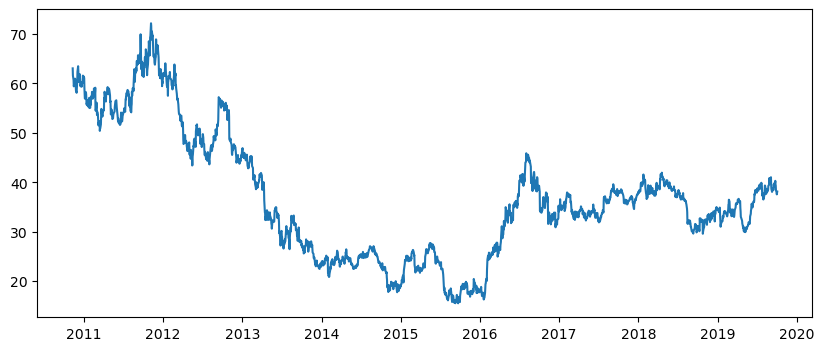

In [4]:
x = pd.to_datetime(df['Date'], format='%Y-%m-%d')
y = df['Close']
high = df['High']
low = df['Low']

plt.figure(figsize=(10, 4))
plt.plot(x, y)

In [5]:
# ---/-----
def get_V(y, h):
    return [y[i+h]/y[i]-1 for i in range(0, len(y)-h)]
    
h = 5

V = get_V(y, h)

In [6]:
x = x[:-h]
y = y[:-h]
high = high[:-h]
low = low[:-h]

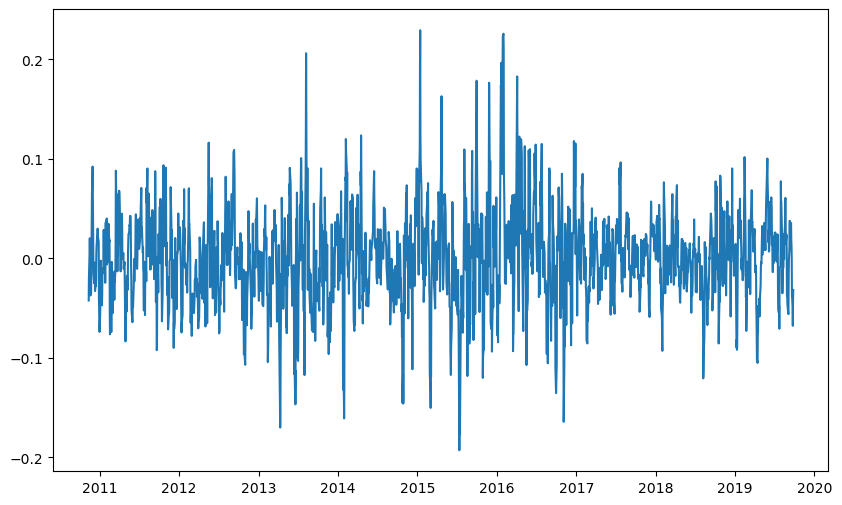

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(x, V)

In [8]:
def get_so(y, high, low, k_period=14, d_period=3):
    # Рассчитываем %K
    data = pd.DataFrame([])
    data['low_min'] = low.rolling(window=k_period, min_periods=1).min()
    data['high_max'] = high.rolling(window=k_period, min_periods=1).max()
    data['stochastic_k'] = ((y - low) / (high - low)) * 100

    # Рассчитываем %D
    data['stochastic_d'] = data['stochastic_k'].rolling(window=k_period, min_periods=1).mean()

    return data['stochastic_d'].tolist(), data['stochastic_k'].tolist()
def calc_rsi(y, period=14):
    delta = y.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = (100 - (100 / (1 + rs))) / 100
    
    return rsi.tolist()

def get_ret(y):
    return [0.0] + list(y[1:]/y[:-1]-1)


def ema_rets(y, w):
    ema = y.ewm(span=w, adjust=False).mean()

    return get_ret(ema.to_numpy())


def fibonacci_retracement(high, low):
    fibonacci_levels = []

    levels=[0.382, 0.5, 0.618, 0.786]
    
    # Calculate the price range
    price_range = high - low

    # Calculate Fibonacci retracement levels
    for level in levels:
        retracement = high - level * price_range
        fibonacci_levels.append(retracement / 100)

    return fibonacci_levels


def get_states(rsi, fib, rets, ema4, ema28, pivot, stoch, past=30): 
    assert len(rsi) == len(fib) == len(rets) == len(ema4) == len(ema28) == len(stoch[1]), 'invalid len in get_states'
    data = pd.DataFrame([])
    data['rsi'] = rsi 
    fib_0 = [fib[i][0] for i in range(len(rsi))]
    fib_1 = [fib[i][1] for i in range(len(rsi))]
    fib_2 = [fib[i][2] for i in range(len(rsi))]
    fib_3 = [fib[i][3] for i in range(len(rsi))]
    data['fib_0'] = fib_0
    data['fib_1'] = fib_1
    data['fib_2'] = fib_2
    data['fib_3'] = fib_3
    data['ema4'] = ema4
    data['ema28'] = ema28
    data['stoch_k'] = stoch[0]
    data['stock_d'] = stoch[1]
    return data

def calculate_pivot_points(high, low, y):
    # Calculate Pivot Point
    pivot = (high + low + y) / 3

    # Calculate Support and Resistance levels
    #support1 = 2 * pivot - high
    #resistance1 = 2 * pivot - low

    #support2 = pivot - (high - low)
    #resistance2 = pivot + (high - low)

    #support3 = low - 2 * (high - pivot)
    #resistance3 = high + 2 * (pivot - low)

    return pivot


def get_X(y, high, low, past=30):
    # rsi
    rsi = calc_rsi(y)
    print('rsi calculated')
    
    # fibonacci
    assert len(high) == len(low), 'invalid fib input'
    fib = [fibonacci_retracement(high[i], low[i]) for i in range(len(high))]
    print('fibonacci calculated')
    
    # returns
    rets = get_ret(y.to_numpy())
    print('returns calculated')
    
    # ema returns
    ema7 = ema_rets(y, 7)
    print('ema7 calculated')
    
    ema14 = ema_rets(y, 14)
    print('ema14 calculated')
    
    # stochasticoscillator
    stoch = get_so(y, high, low)
    
    #pivot
    pivot = calculate_pivot_points(high, low, y)
    
    return get_states(rsi, fib, rets, ema7, ema14, pivot, stoch, past)

past = 30

X = get_X(y, high, low, past)
X = X[past:]

V = pd.DataFrame(V[past:])

rsi calculated
fibonacci calculated
returns calculated
ema7 calculated
ema14 calculated


In [9]:
len(X), len(V)

(2203, 2203)

In [11]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'}
}
model = LGBMRegressor(random_state=42)
model.fit(X, V)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2203, number of used features: 9
[LightGBM] [Info] Start training from score 0.000081


LGBMRegressor(random_state=42)

In [12]:
model.score(X, V)
r2_score(V, model.predict(X))

0.6915105357462609

In [13]:
past = 30
test_df = csv.iloc[N:]
test_df = test_df.reset_index(drop=True)
test_X = get_X(test_df['Close'], test_df['High'], test_df['Low'], past)
test_X = test_X[past:-h]
test_y = test_df['Close'].iloc[past+h:].to_numpy()
test_high = test_df['High'].iloc[past+h:].to_numpy()

rsi calculated
fibonacci calculated
returns calculated
ema7 calculated
ema14 calculated


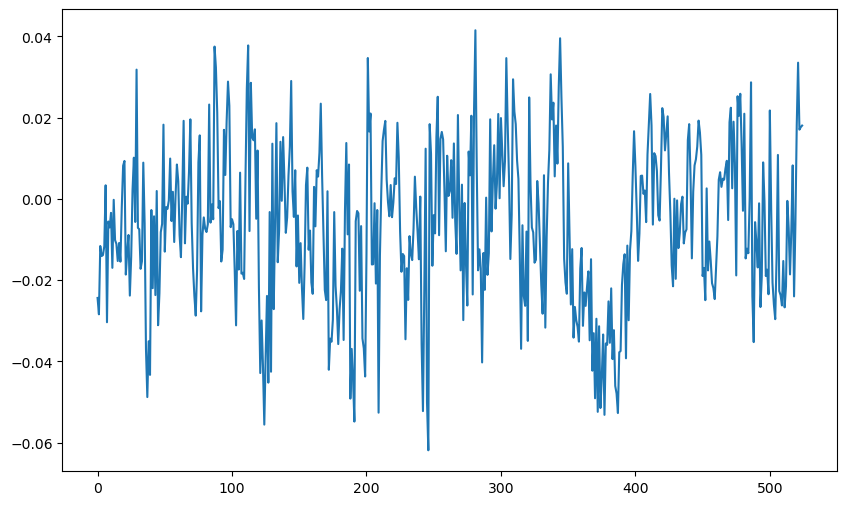

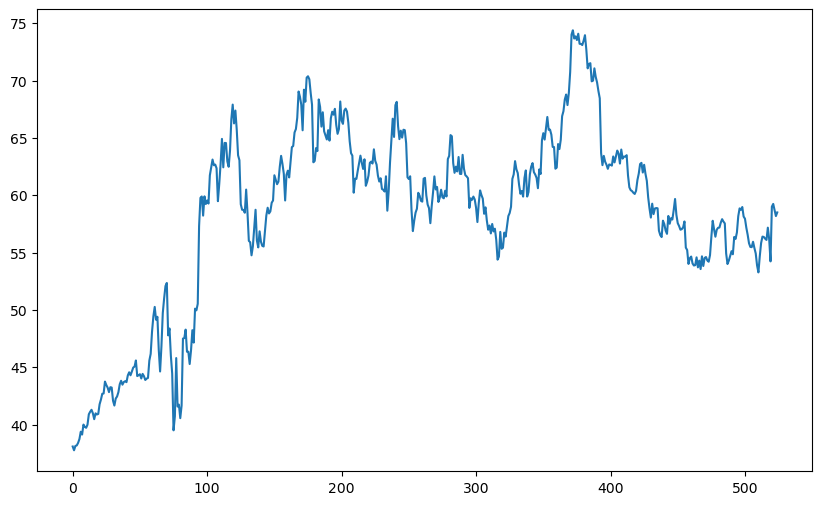

In [14]:
pred = model.predict(test_X)
plt.figure(figsize=(10, 6))
plt.plot(pred)
plt.figure(figsize=(10, 6))
plt.plot(test_y)

In [15]:
r2_score(test_y, model.predict(test_X))

-53.81552820656685

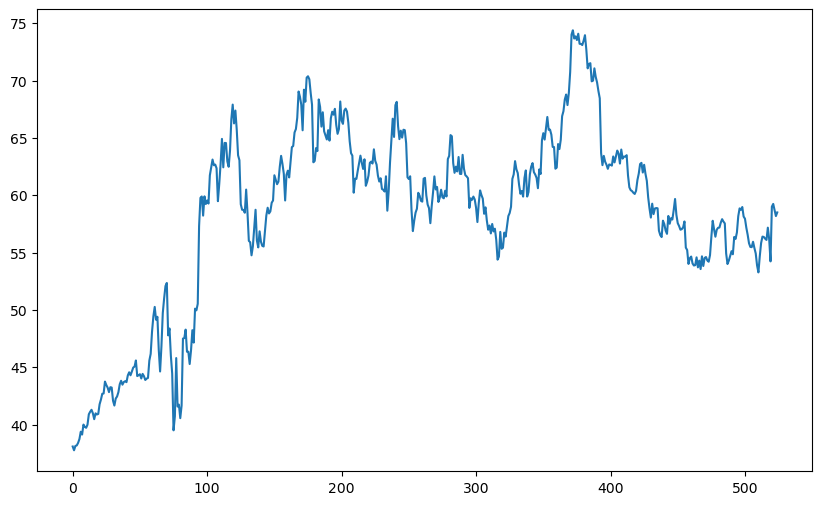

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(test_y)

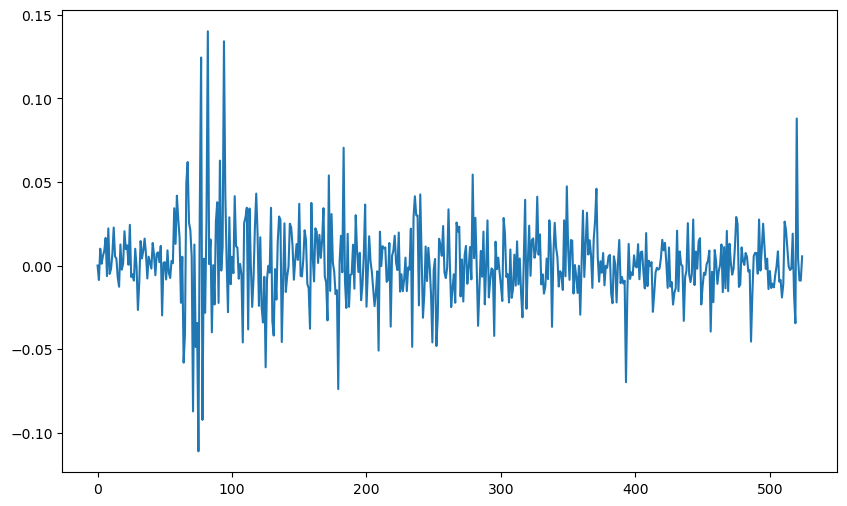

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(get_ret(test_y))

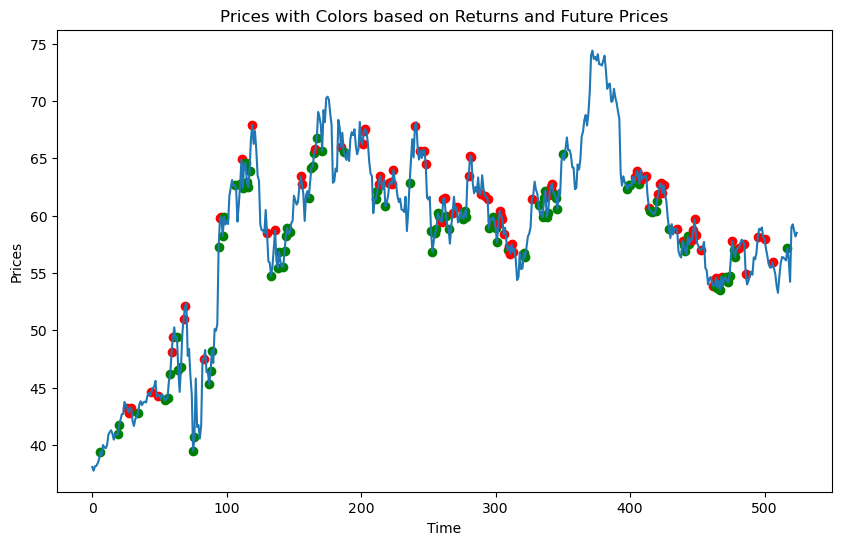

In [19]:
import matplotlib.pyplot as plt

prices = test_y
highs = test_high
returns = pred
plt.figure(figsize=(10, 6))

for i in range(len(prices) - h):
    future_price = prices[i + h]
    
    if returns[i] > 0.0 and future_price >= prices[i]:
        plt.scatter(i, prices[i], color='green', marker='o')
    elif returns[i] > 0.0 and future_price < prices[i]:
        plt.scatter(i, prices[i], color='red', marker='o')

plt.plot(prices)
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Prices with Colors based on Returns and Future Prices')
plt.show()